In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
DATA_IN = '../data/raw/'
DATA_OUT = '../data/clean/'

# Data Import

## Line list

2015-2016 (through June 2016) in stata format

In [3]:
line_list_raw = (pd.read_stata(DATA_IN+'linelist_latin_20160717.dta', convert_dates=True)
                     .drop(['agemonth', 'ageyear'], axis=1)
                     .set_index('id'))

Convert remaining date fields

In [4]:
line_list_date_cols = ['onsetofdisease'] + line_list_raw.columns[line_list_raw.columns.str.contains('date')].tolist()

for col in line_list_date_cols:
    try:
        line_list_raw[col] = pd.to_datetime(line_list_raw[col])
    except ValueError:
        pass

Drop fields with >75% missing values.

In [5]:
line_list_raw = line_list_raw.dropna(axis=1, thresh=int(line_list_raw.shape[0]*0.10))
line_list_raw.shape

(49908, 190)

In [6]:
line_list_raw.head()

,idnumber,dateofbirth,age,gender,u5_gender,addressaimagcity,discrictsoum,khoroobagh,bairgudamj,numberofpersonlivingathome,...,aimag,id_numeric,icd_main,icd_2,icd_3,icd_4,_merge,match_note,died_enhanced,date_onset_2016
id,,,,,,,,,,,,,,,,,,,,,
389.0,UK14290198,1-Sep-2014,210.0,Male,Male,Ulaanbaatar,BZD,13,duureg 3-84,4,...,Ulaanbaatar,14290198,"Contact with hot drinks, food, fats and cookin...",Burns and corrosions of multiple body regions*,Other sepsis*,Missing,3,,0.0,1970-01-01
707.0,UP13220251,2-Feb-2013,790.0,Male,Male,Ulaanbaatar,SKhD,16,25-87 toot,3,...,Ulaanbaatar,13220251,"Pneumonia, organism unspecified*","Pneumonia, organism unspecified*",Missing,Missing,3,,1.0,1970-01-01
1762.0,RI15210414,4-Jan-2015,100.0,Male,Male,Khovsgol,ryenchinlkhumbe,4,gert,4,...,Khvsgl,15210414,"Pneumonia, organism unspecified*",Missing,Missing,Missing,3,,1.0,1970-01-01
2061.0,UK14292376,23-Sep-2014,211.0,Male,Male,Ulaanbaatar,BZD,13,5--26,4,...,East,14292376,Car occupant injured in noncollision transport...,Car occupant injured in noncollision transport...,Missing,Missing,3,,0.0,1970-01-01
6465.0,AZ13321825,18-Dec-2013,510.0,Female,Female,Ulaanbaatar,BZD,22,zau 10-199,3,...,Ulaanbaatar,13321825,Other congenital malformations of heart*,Missing,Missing,Missing,3,,1.0,1970-01-01


In [7]:
line_list_raw.dtypes.value_counts()

object            129
float32            25
datetime64[ns]     19
float64             6
category            2
int8                2
category            1
category            1
category            1
category            1
category            1
category            1
category            1
dtype: int64

In [8]:
cols_to_keep = ['date_onset', 'provincecity', 'sex', 'dob_final', 'age_years', 'died_enhanced', 
                'confirmed', 'labconfirmed', 'date_lab', 'vaccine_ever']

line_list = line_list_raw[cols_to_keep]

In [9]:
line_list.head()

,date_onset,provincecity,sex,dob_final,age_years,died_enhanced,confirmed,labconfirmed,date_lab,vaccine_ever
id,,,,,,,,,,
389.0,2015-03-30,UB,Male,2014-09-01,0.577686,0.0,1.0,1.0,2015-04-06,0.0
707.0,2015-04-03,UB,Male,2013-02-02,2.162902,1.0,1.0,1.0,2015-04-04,0.0
1762.0,2015-04-14,KhU,Male,2015-01-04,0.279261,1.0,1.0,0.0,NaT,0.0
2061.0,2015-04-22,UB,Male,2014-09-23,0.577686,0.0,1.0,1.0,2015-04-24,0.0
6465.0,2015-05-12,UB,Female,2013-12-18,1.314168,1.0,0.0,0.0,NaT,0.0


Additional line list data (July to December 2016)

In [10]:
line_list_2016_raw = pd.read_csv(DATA_IN + 'MNG2016 (July to Dec).csv', index_col=0, parse_dates=True)
line_list_2016_raw.columns = ['_'.join(x) for x in line_list_2016_raw.columns.str.lower().str.replace('\r','').str.split(' ').values]

In [11]:
for date_field in ('donset', 'dob', 'dscoll', 'dlabrec'):
    line_list_2016_raw[date_field] = pd.to_datetime(line_list_2016_raw[date_field])

In [12]:
cols_to_keep_2016 = ['donset', 'infection_province', 'sex', 'dob', 'age', 'outcome',  
                'mclass', 'mconfmeth', 'dlastvac', 'dlabrec']
line_list_2016 = line_list_2016_raw[cols_to_keep_2016].copy()

Recode variables to match main dataset

In [13]:
province_lookup = {'AR':'Arkhangai',
    'Bay':'Bayan Ulgii',
    'BKh':'Bayankhongor',
    'BU':'Bulgan',
    'DA':'Darkhan-Uul',
    'DG':'Dornogobi',
    'DO':'Dornod',
    'DU':'Dundgovi',
    'GA':'Gobi altai',
    'GS':'Govisumber',
    'KhE':'Khentii',
    'KhO':'Khovd',
    'KhU':'Khuvsgul',
    'OR':'Orkhon',
    'SB':'Sukhbaatar',
    'SE':'Selenge',
    'TU':'Tuv',
    'UB':'Ulaanbaatar',
    'UG':'Umnogovi',
    'UV':'Uvurkhangai',
    'UVs':'Uvs',
    'ZA':'Zavkhan'}

inverse_province_lookup = res = dict((v,k) for k,v in province_lookup.items())

In [14]:
line_list_2016 = (line_list_2016.assign(provincecity=line_list_2016.infection_province.replace(inverse_province_lookup),
                                       confirmed=(line_list_2016.mclass==1).astype(int),
                                       labconfirmed=((line_list_2016.mclass==1) 
                                                     & (line_list_2016.mconfmeth==1)).astype(int),
                                       male=(line_list_2016.sex=='Male').astype(int),
                                       died=(line_list_2016.outcome==2).astype(int),
                                       vaccine_ever=line_list_2016.dlastvac.notnull().astype(int))
                        .drop(['outcome', 'mconfmeth', 'mclass', 'sex', 'infection_province', 'dlastvac'], axis=1)
                        .rename(columns={'age':'age_years', 
                                         'donset':'date_onset',
                                        'dlabrec':'date_lab'})
                 )

In [15]:
line_list_2016.shape

(442, 10)

In [16]:
line_list = (line_list.assign(male=line_list.sex=='Male')
                    .drop(['sex'], axis=1)
                    .rename(columns={'dob_final':'dob',
                                    'died_enhanced':'died'})
            )

In [17]:
line_list.shape

(49908, 10)

In [18]:
line_list_merged = pd.concat([line_list, line_list_2016], ignore_index=True)

/home/fonnesbeck/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [19]:
line_list_merged.head()

,age_years,confirmed,date_lab,date_onset,died,dob,labconfirmed,male,provincecity,vaccine_ever
0,0.577686,1.0,2015-04-06,2015-03-30,0.0,2014-09-01,1.0,1,UB,0.0
1,2.162902,1.0,2015-04-04,2015-04-03,1.0,2013-02-02,1.0,1,UB,0.0
2,0.279261,1.0,NaT,2015-04-14,1.0,2015-01-04,0.0,1,KhU,0.0
3,0.577686,1.0,2015-04-24,2015-04-22,0.0,2014-09-23,1.0,1,UB,0.0
4,1.314168,0.0,NaT,2015-05-12,1.0,2013-12-18,0.0,0,UB,0.0


In [20]:
line_list_merged.shape

(50350, 10)

In [21]:
line_list['month_onset'] = line_list.date_onset.dt.month
line_list['year_onset'] = line_list.date_onset.dt.year

In [22]:
line_list.isnull().mean().round(2)

date_onset      0.01
provincecity    0.00
dob             0.00
age_years       0.01
died            0.00
confirmed       0.00
labconfirmed    0.00
date_lab        0.86
vaccine_ever    0.49
male            0.00
month_onset     0.01
year_onset      0.01
dtype: float64

Monthly distribution of all cases

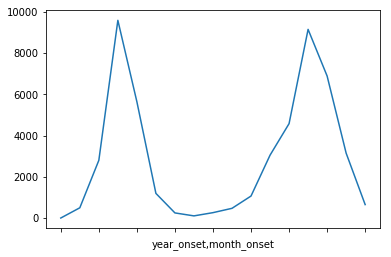

In [23]:
line_list.groupby(['year_onset', 'month_onset']).date_onset.count().plot()

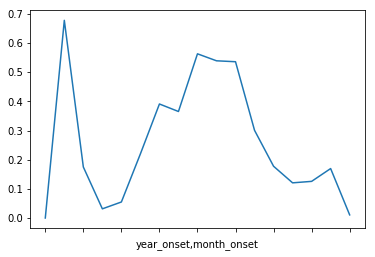

In [24]:
line_list.groupby(['year_onset', 'month_onset']).date_lab.apply(lambda x: x.notnull().mean()).plot()

Monthly distribution of lab-confirmed only

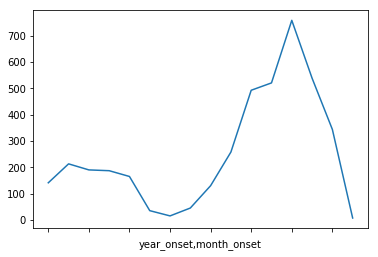

In [25]:
line_list[line_list.labconfirmed==1].groupby(['year_onset', 'month_onset']).date_onset.count().plot()

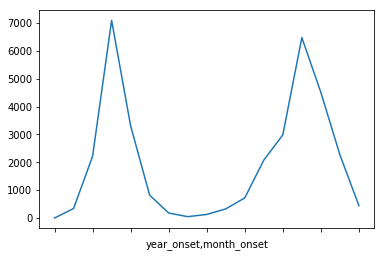

In [26]:
line_list[line_list.confirmed==1].groupby(['year_onset', 'month_onset']).date_onset.count().plot()

Export merged data

In [27]:
line_list.to_csv(DATA_OUT+'line_list.csv')

## Biweekly counts of cases

In [28]:
line_list.head()

,date_onset,provincecity,dob,age_years,died,confirmed,labconfirmed,date_lab,vaccine_ever,male,month_onset,year_onset
id,,,,,,,,,,,,
389.0,2015-03-30,UB,2014-09-01,0.577686,0.0,1.0,1.0,2015-04-06,0.0,True,3.0,2015.0
707.0,2015-04-03,UB,2013-02-02,2.162902,1.0,1.0,1.0,2015-04-04,0.0,True,4.0,2015.0
1762.0,2015-04-14,KhU,2015-01-04,0.279261,1.0,1.0,0.0,NaT,0.0,True,4.0,2015.0
2061.0,2015-04-22,UB,2014-09-23,0.577686,0.0,1.0,1.0,2015-04-24,0.0,True,4.0,2015.0
6465.0,2015-05-12,UB,2013-12-18,1.314168,1.0,0.0,0.0,NaT,0.0,False,5.0,2015.0


Assign age groups

In [29]:
age_classes = [0,5,10,15,20,25,30,35,40,100]
line_list['age_group'] = pd.cut(line_list.age_years, age_classes, right=False)

In [30]:
dates_index = line_list.groupby(['date_onset', 'age_group']).size().unstack().index

In [31]:
confirmed_data = line_list.query('confirmed==1')
confirmed_counts_2w = (confirmed_data
                        .groupby(['date_onset', 'age_group'])
                        .size()
                        .unstack()
                        .reindex(dates_index)
                        .fillna(0)
                        .resample('2W')
                        .sum())

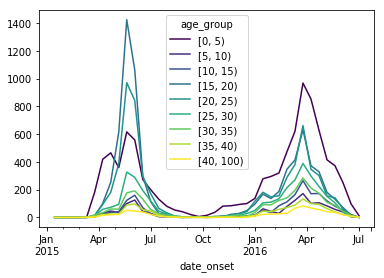

In [32]:
confirmed_counts_2w.plot(cmap='viridis')

In [33]:
confirmed_counts_2w.to_csv(DATA_OUT+'confirmed_counts.csv')

## Birth cohort

Routine and SIA vaccination coverage, birth cohort population size, and total suspected cases in each year since 1925

MCV is coverage proportion

In [38]:
birth_cohort_raw = pd.read_csv(DATA_IN+'birth cohort.csv', index_col=0)
birth_cohort_raw.tail(10)

,Birth cohort,Measles.cases,MCV1,MCV2,SIA 1994 (M),SIA 1996 (M),SIA 2000 (M),SIA 2007 (M),SIA 2012 (MR),Target,Coverage.survey,serosurvey 2004,sero1996,sero9799,Population,Total cases
Age,,,,,,,,,,,,,,,,
9,2006,15.0,0.99,0.97,NaN,NaN,NaN,NaN,0.97,0.95,NaN,NaN,NaN,NaN,53106.2,26.0
8,2007,16.0,0.98,0.96,NaN,NaN,NaN,NaN,0.96,0.95,NaN,NaN,NaN,NaN,53106.2,12.0
7,2008,22.0,0.97,0.97,NaN,NaN,NaN,NaN,0.96,0.95,NaN,NaN,NaN,NaN,53106.2,31.0
6,2009,24.0,0.94,0.93,NaN,NaN,NaN,NaN,0.90,0.95,88.0,NaN,NaN,NaN,53106.2,8.0
5,2010,38.0,0.98,0.97,NaN,NaN,NaN,NaN,NaN,0.95,NaN,NaN,NaN,NaN,53106.2,7.0
4,2011,53.0,0.98,0.99,NaN,NaN,NaN,NaN,NaN,0.95,NaN,NaN,NaN,NaN,67706.8,0.0
3,2012,71.0,0.99,0.99,NaN,NaN,NaN,NaN,NaN,0.95,NaN,NaN,NaN,NaN,67706.8,0.0
2,2013,158.0,0.99,0.99,NaN,NaN,NaN,NaN,NaN,0.95,NaN,NaN,NaN,NaN,67706.8,0.0
1,2014,682.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,0.95,NaN,NaN,NaN,NaN,67706.8,0.0


In [39]:
birth_cohort_raw.isnull().sum()

Birth cohort        0
Measles.cases      33
MCV1               56
MCV2               76
SIA 1994 (M)       86
SIA 1996 (M)       80
SIA 2000 (M)       84
SIA 2007 (M)       82
SIA 2012 (MR)      79
Target             67
Coverage.survey    89
serosurvey 2004    24
sero1996           89
sero9799           31
Population          0
Total cases        51
dtype: int64

In [45]:
coverage_cols = (birth_cohort_raw.columns.str.startswith('SIA') |
                 birth_cohort_raw.columns.str.startswith('MCV'))
coverage = birth_cohort_raw[birth_cohort_raw.columns[coverage_cols]].fillna(0)

In [46]:
coverage.to_csv(DATA_OUT + 'coverage.csv')

## Supplemental immunization

Details of coverage of outbreak response campaigns in 2015 and 2016, by age group and Aimag

In [7]:
sia_2015 = pd.read_excel(DATA_IN+'MR SIA 2015.xlsx', skiprows=49, index_col=0).dropna(axis=1)
sia_2015

,0,1,2,3,4,5
Arkhangai,860,1840,1843,1873,1808,1837
Bayan-Ulgii,1361,2203,2447,2233,2186,1872
Bayankhongor,928,1631,1797,1854,1710,2019
Bulgan,574,1084,1195,1139,1076,1430
Gobi-Altai,494,989,1132,1183,1186,1276
Gobisumber,210,404,376,362,357,391
Darkhan-uul,1205,2162,2081,2094,2071,2115
Dornogobi,780,1391,1483,1455,1419,1496
Dornod,555,797,1147,1335,1344,1953
Dundgobi,400,782,811,835,853,1127


In [33]:
sia_2016 = pd.read_excel(DATA_IN+'MR SIA 2016.xlsx', skiprows=2, index_col=0).drop('TOTAL').dropna()

In [34]:
sia_2016.index.name = 'age'

In [35]:
sia_2016.index = pd.Series(sia_2016.index.str.split(' ')).apply(lambda x: int(x[0]))

In [36]:
sia_2016.tail()

,AR,Bay,BKh,BU,GA,GS,DA,DG,DO,DU,...,UG,SB,SE,TU,Uvs,KhO,KhU,KhE,UB,TOTAL
age,,,,,,,,,,,,,,,,,,,,,
26,1125.0,1338.0,1292.0,765.0,727.0,310.0,1379.0,1161.0,1057.0,562.0,...,1016.0,913.0,1855.0,1461.0,937.0,1131.0,1684.0,958.0,25282.0,48428.0
27,1140.0,1263.0,1276.0,741.0,732.0,325.0,1264.0,1168.0,983.0,571.0,...,1112.0,889.0,1878.0,1363.0,926.0,1092.0,1694.0,920.0,24421.0,47394.0
28,1069.0,1240.0,1204.0,735.0,721.0,290.0,1364.0,1084.0,1001.0,530.0,...,1057.0,868.0,1706.0,1376.0,871.0,1056.0,1664.0,960.0,23952.0,46230.0
29,1067.0,1156.0,1195.0,728.0,685.0,266.0,1232.0,1093.0,952.0,557.0,...,1053.0,860.0,1713.0,1294.0,848.0,971.0,1577.0,930.0,21818.0,43462.0
30,1332.0,1290.0,1425.0,772.0,797.0,419.0,1444.0,1073.0,1066.0,608.0,...,1081.0,1138.0,1903.0,1612.0,916.0,1239.0,2022.0,1017.0,28994.0,54439.0


In [37]:
sia_2016.shape

(13, 23)

## Population

Population by age group in each province

In [38]:
population = pd.read_csv(DATA_IN+'denominators.csv', index_col=0)
population.head()

,Total,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70+
Province,,,,,,,,,,,,,,,,
Arkhangai,92896,10440,8360,7883,9249,9469,8207,6856,6824,6294,5498,4643,3266,2202,1237,2468
Bayan-Ulgii,93165,11655,10219,9929,8794,8872,8531,7207,6199,5713,4633,3842,2747,1665,1006,2153
Bayankhongor,79310,9760,7429,6675,7812,7992,7436,6280,5806,5165,4383,3714,2436,1480,1008,1934
Bulgan,60324,6415,5351,4556,5423,5587,4977,4499,4592,4426,4066,3494,2619,1666,877,1776
Gobi-Altai,56698,5953,5392,5046,5778,5631,4837,4401,4345,3994,3389,2730,1974,1064,706,1458


## Contact Matrix

In [43]:
labels = ('0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44',
          '45-49','50-54','55-59','60-64','65-69','70-74','75-79')

In [44]:
contact_matrix = pd.read_excel(DATA_IN + 'MUestimates_all_locations_1.xlsx', sheet_name='Mongolia')

In [46]:
contact_matrix.index = labels
contact_matrix.columns = labels

contact_matrix

,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79
0-4,4.401237,1.763937,0.919437,0.624498,1.046207,1.482324,1.597269,1.272634,0.699138,0.433154,0.416952,0.298704,0.165690,0.113663,0.055602,0.028512
5-9,1.516642,5.579821,1.636800,0.526566,0.376492,0.835530,1.069852,1.042002,0.776664,0.350450,0.223292,0.179960,0.125074,0.080201,0.034378,0.021354
10-14,0.565305,2.430136,9.173725,1.338731,0.678906,0.561664,0.752270,0.978849,0.977257,0.548473,0.279455,0.125108,0.073774,0.073519,0.046311,0.028149
15-19,0.362383,0.735950,3.880892,12.329158,2.484105,1.114497,0.791941,1.044384,1.084481,0.910513,0.431088,0.159695,0.075093,0.050912,0.025332,0.014883
20-24,0.690604,0.494602,0.654419,4.388705,6.874433,2.877837,1.696849,1.357469,1.114796,1.148850,0.673750,0.312985,0.094083,0.042085,0.036185,0.024778
25-29,1.131658,0.595173,0.338302,1.246928,3.310355,4.037476,2.297427,1.669579,1.296032,0.982625,0.758283,0.327918,0.127142,0.048662,0.017451,0.014078
30-34,1.119065,1.429785,1.129042,0.688325,1.518715,2.327752,2.878892,2.130290,1.515147,1.039982,0.658296,0.352173,0.170007,0.062183,0.029989,0.019242
35-39,1.023034,1.463183,1.288895,0.932610,0.988366,1.654279,2.022704,2.659283,2.025621,1.168606,0.649874,0.267570,0.167301,0.102396,0.049020,0.015894
40-44,0.636548,1.050247,1.286703,1.370933,1.132353,1.331960,1.699263,1.871622,2.210152,1.397962,0.758460,0.195135,0.127805,0.083993,0.042570,0.019716
45-49,0.532940,0.761511,0.889693,1.611893,0.998319,1.016777,1.177551,1.329233,1.327717,1.293341,0.707390,0.232359,0.084176,0.046590,0.036707,0.033541


In [47]:
contact_matrix.to_csv(DATA_OUT + 'contact_matrix.csv')